Developing a classifier:
========================
* Review of image as array
* Computing statistics on selected regions
* Filtering data via Boolean masking
* Using statistics to build an NDVI classifier
* Creating classifiers for water, building, clouds

In [54]:
#read in data
import os
import landsat as lf
folder = "data" 
rgbfile = "landsat_RGBN.txt" 
rgbn = lf.landsat_read(os.path.join(folder, rgbfile))

In [2]:
# compute the array at a given contrast
rgb_array = lf.rgb_contrast(rgbn[...,:3], 3)

How do we subset data?
======================
![figs](figs/slice.png)
src: [scipy lectures](http://www.scipy-lectures.org/intro/numpy/array_object.html#indexing-and-slicing)


<IPython.core.display.Javascript object>


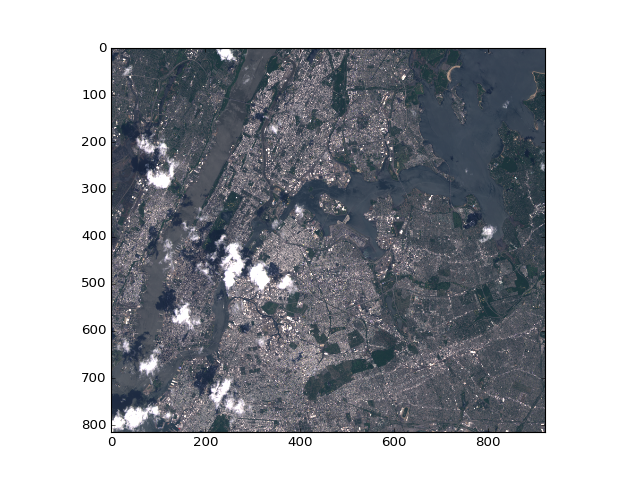

In [4]:
#use zoom to find region of interest
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.imshow(rgb_array, origin="upper")

<IPython.core.display.Javascript object>


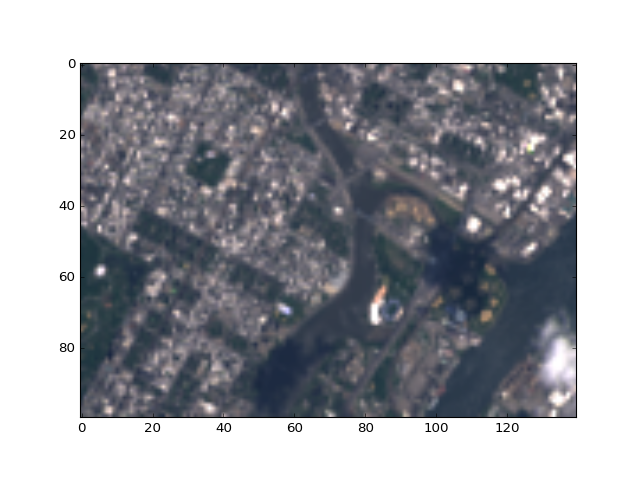

In [6]:
# xbounds: 260, 360
# ybounds: 260, 400
x1, x2 = 260, 360
y1, y2 = 260, 400
subset = rgb_array[x1:x2, y1:y2]
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.imshow(subset)

<IPython.core.display.Javascript object>


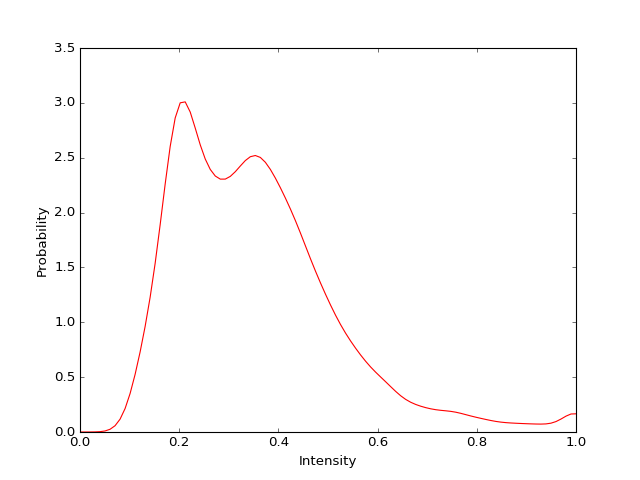

In [7]:
# plot pdf of red in that region
red = subset[...,0]

import scipy.stats as st
import numpy as np

#estimate the P function of the distribution
kernal = st.gaussian_kde(red.flatten())
# color values range between 0 & 1 
x = np.linspace(0,1,100) #the range of potential color values
y = kernal(x) #probability of each x happening

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x, y, color='red')
ax.set_xlabel("Intensity")
ax.set_ylabel("Probability")

# now add the pdfs for green & blue

ToDo
=====
1. select a few other regions and plot the related pdfs
2. try to find a relationship between pdfs and different features of the region (like land or water)


How do we filter data?
======================================
![boolean mask](figs/masking.png)

In [49]:
#unpack red, green, blue
red = rgb_array[...,0]
green = rgb_array[...,1]
blue = rgb_array[...,2]

#lets build an arbitrary blue mask
bmean = blue.mean()
print(bmean)
blue_mask = (blue>bmean)
print (blue_mask)

0.396816828867
[[ True False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [ True  True  True ...,  True False False]
 [ True  True  True ...,  True  True  True]
 [ True  True  True ..., False False  True]]


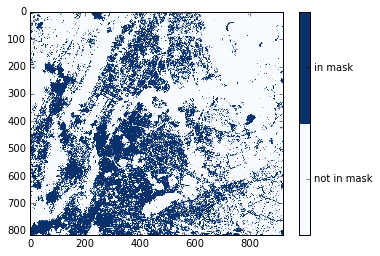

In [50]:
import numpy as np
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
#what does that mean?

cmap = mcm.Blues
norm = mcolors.BoundaryNorm([0,1,2],cmap.N)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(blue_mask, cmap=cmap, norm=norm)
cb = fig.colorbar(im, ax=ax)
cb.set_ticks([0.5,1.5])
cb.set_ticklabels(["not in mask","in mask"])
fig.canvas.draw()

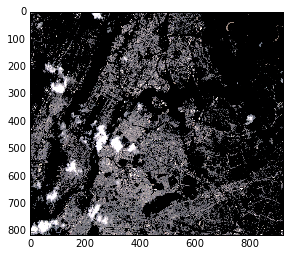

In [51]:
%matplotlib inline
#plot only the data shown in the map
rgb_copy = rgb_array.copy()
rgb_copy[~blue_mask,:] = np.nan
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(rgb_copy)

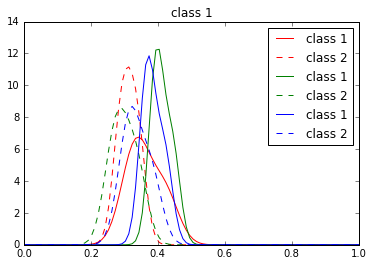

In [52]:
#compare data in mask to data not in mask:
class1 = rgb_array[blue_mask] # data in mask
class2 = rgb_array[~blue_mask] # data outside of mask

x = np.linspace(0,1,100) 
def pdf(data):
    kernal = st.gaussian_kde(data.flatten())  
    y = kernal(x) 
    return y

colors = ['red', 'green','blue']
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_title("class 1")
for i, c in enumerate(colors):
    ax.plot(x, pdf(class1[i]), color=c, label="class 1")
    ax.plot(x, pdf(class2[i]), color=c, linestyle='--', label='class 2')

ax.legend()

1. Was blue mean a good seperator?
2. Try using red channel and green channel

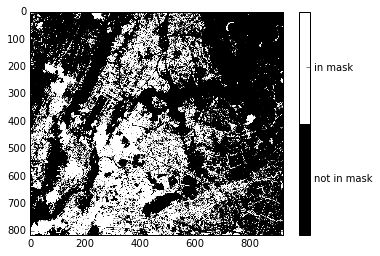

In [53]:
#combine masks and show which region is in both
blue_mask = (blue>blue.mean())
red_mask = (red>red.mean())
comb_mask = (blue_mask & red_mask)

cmap = mcm.bone
norm = mcolors.BoundaryNorm([0,1,2],cmap.N)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
im = ax.imshow(comb_mask, cmap=cmap, norm=norm)
cb = fig.colorbar(im, ax=ax)
cb.set_ticks([0.5,1.5])
cb.set_ticklabels(["not in mask","in mask"])
fig.canvas.draw()

ToDo
=====
 1. Apply combined mask to data
 2. Compare data the two classes (mask & non-mask)
 2. Explore different thresholds for each of the color channels using the histograms you made above
 3. Combine various thresholds
 4. See if combination masks can highlight/yield features in the dataset
 5. Compute histograms of the masked data